##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Forecasting with machine learning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c05_forecasting_with_machine_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c05_forecasting_with_machine_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

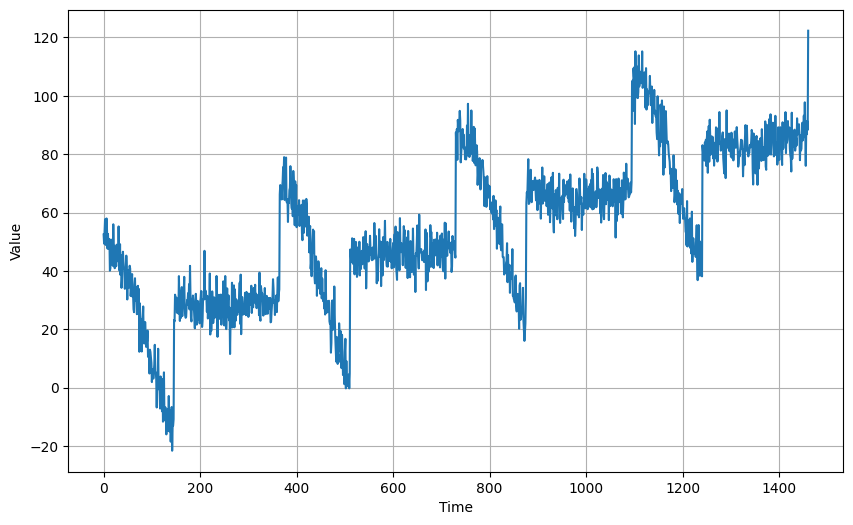

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

## Forecasting with Machine Learning

First, we will train a model to forecast the next step given the previous 30 steps, therefore, we need to create a dataset of 30-step windows for training.

In [4]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [5]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

### Linear Model

In [6]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.fit(train_set, epochs=100, validation_data=valid_set)

Epoch 1/100
31/31 [==============================] - 1s 20ms/step - loss: 392.5132 - mae: 393.0124 - val_loss: 148.7836 - val_mae: 149.2836
Epoch 2/100
31/31 [==============================] - 0s 4ms/step - loss: 628.7576 - mae: 629.2576 - val_loss: 1300.2588 - val_mae: 1300.7588
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 832.2100 - mae: 832.7099 - val_loss: 805.9301 - val_mae: 806.4301
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 356.5014 - mae: 357.0008 - val_loss: 638.3342 - val_mae: 638.8342
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 415.6956 - mae: 416.1944 - val_loss: 489.7811 - val_mae: 490.2811
Epoch 6/100
31/31 [==============================] - 0s 4ms/step - loss: 350.8338 - mae: 351.3335 - val_loss: 1429.6039 - val_mae: 1430.1039
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 387.9962 - mae: 388.4957 - val_loss: 89.3129 - val_mae: 89.8115
Epoch 8/100
31/31 [=====

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 3ms/step - loss: 127.0828 - mae: 127.5823 - lr: 1.0000e-06
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 111.5167 - mae: 112.0164 - lr: 1.0798e-06
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 93.1900 - mae: 93.6895 - lr: 1.1659e-06
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 73.5172 - mae: 74.0159 - lr: 1.2589e-06
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 52.5728 - mae: 53.0728 - lr: 1.3594e-06
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 30.5415 - mae: 31.0406 - lr: 1.4678e-06
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 13.0859 - mae: 13.5759 - lr: 1.5849e-06
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 10.5740 - mae: 11.0636 - lr: 1.7113e-06
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 10.4835 - mae: 10.9

(1e-06, 0.001, 0.0, 20.0)

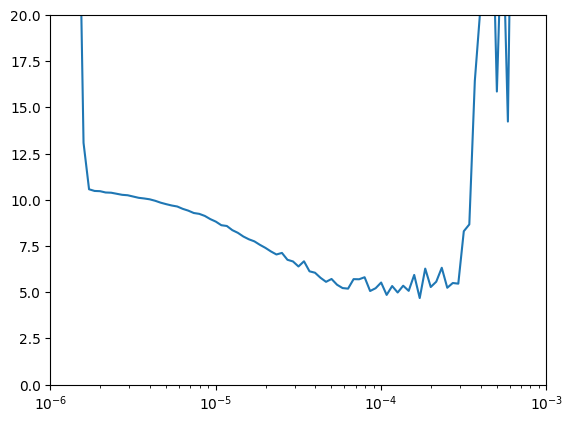

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])

In [9]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 10ms/step - loss: 548.0763 - mae: 548.5763 - val_loss: 727.7450 - val_mae: 728.2450
Epoch 2/500
31/31 [==============================] - 0s 4ms/step - loss: 559.9632 - mae: 560.4629 - val_loss: 2376.3408 - val_mae: 2376.8408
Epoch 3/500
31/31 [==============================] - 0s 7ms/step - loss: 963.2892 - mae: 963.7889 - val_loss: 3365.4858 - val_mae: 3365.9858
Epoch 4/500
31/31 [==============================] - 0s 7ms/step - loss: 860.6982 - mae: 861.1982 - val_loss: 1663.7294 - val_mae: 1664.2294
Epoch 5/500
31/31 [==============================] - 0s 8ms/step - loss: 457.4923 - mae: 457.9915 - val_loss: 1120.2714 - val_mae: 1120.7714
Epoch 6/500
31/31 [==============================] - 1s 15ms/step - loss: 643.3885 - mae: 643.8882 - val_loss: 1047.4000 - val_mae: 1047.9000
Epoch 7/500
31/31 [==============================] - 0s 7ms/step - loss: 658.4706 - mae: 658.9701 - val_loss: 128.0592 - val_mae: 128.5592
Epoch 8/500
31/

In [10]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [11]:
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

15/15 [==============================] - 0s 6ms/step


In [12]:
lin_forecast.shape

(461,)

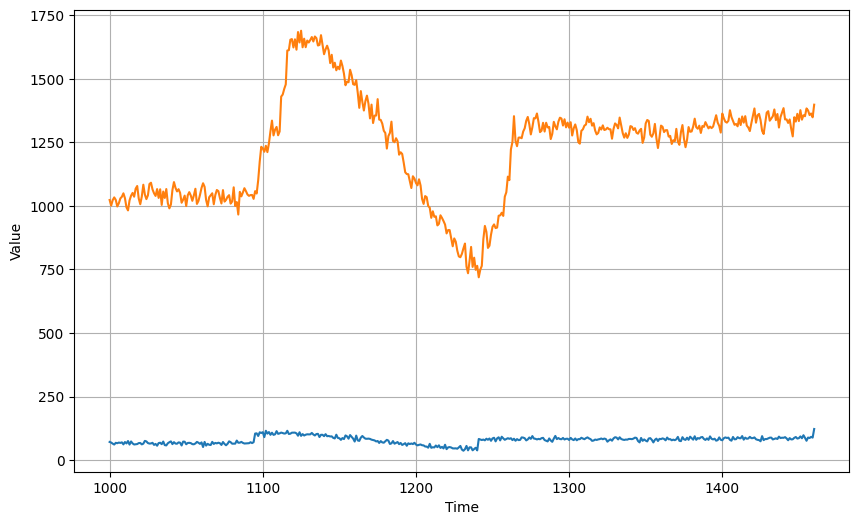

In [13]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [14]:
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

1147.6561

### Dense Model Forecasting

In [15]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 3ms/step - loss: 104.1766 - mae: 104.6762 - lr: 1.0000e-07
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 102.6365 - mae: 103.1364 - lr: 1.1220e-07
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 100.7821 - mae: 101.2821 - lr: 1.2589e-07
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 98.7334 - mae: 99.2334 - lr: 1.4125e-07
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 96.4788 - mae: 96.9788 - lr: 1.5849e-07
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 93.9899 - mae: 94.4899 - lr: 1.7783e-07
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 91.2501 - mae: 91.7497 - lr: 1.9953e-07
Epoch 8/100
31/31 [==============================] - 0s 1ms/step - loss: 88.2263 - mae: 88.7263 - lr: 2.2387e-07
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 84.9082 - mae: 85

(1e-07, 0.005, 0.0, 30.0)

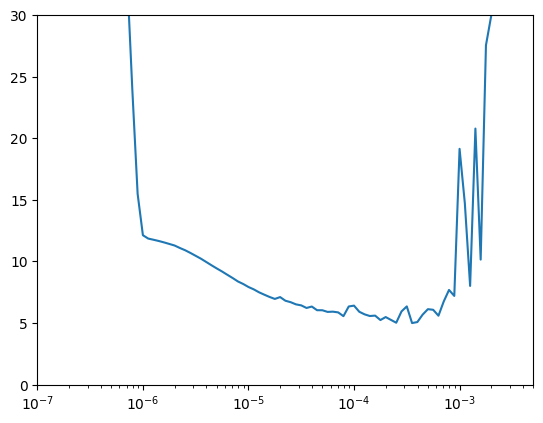

In [16]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 5e-3, 0, 30])

In [17]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 10ms/step - loss: 57.6104 - mae: 58.1104 - val_loss: 76.2925 - val_mae: 76.7925
Epoch 2/500
31/31 [==============================] - 0s 5ms/step - loss: 34.7180 - mae: 35.2168 - val_loss: 52.0198 - val_mae: 52.5198
Epoch 3/500
31/31 [==============================] - 0s 4ms/step - loss: 16.6880 - mae: 17.1812 - val_loss: 37.0982 - val_mae: 37.5977
Epoch 4/500
31/31 [==============================] - 0s 4ms/step - loss: 16.0564 - mae: 16.5510 - val_loss: 35.6834 - val_mae: 36.1815
Epoch 5/500
31/31 [==============================] - 0s 4ms/step - loss: 15.9874 - mae: 16.4784 - val_loss: 33.4749 - val_mae: 33.9738
Epoch 6/500
31/31 [==============================] - 1s 15ms/step - loss: 16.1409 - mae: 16.6348 - val_loss: 33.5009 - val_mae: 33.9999
Epoch 7/500
31/31 [==============================] - 1s 9ms/step - loss: 16.2173 - mae: 16.7116 - val_loss: 33.1816 - val_mae: 33.6789
Epoch 8/500
31/31 [==============================] - 

In [18]:
dense_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

15/15 [==============================] - 1s 7ms/step


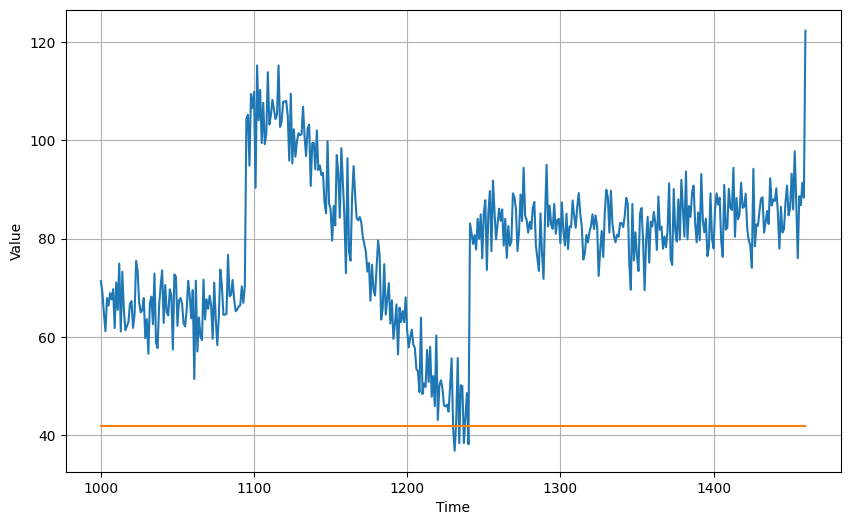

In [19]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dense_forecast)

In [20]:
keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy()

36.608967